# Problem Statement

ABC is a car rental company based out of Bangalore. It rents cars for both in and out stations at affordable prices. The users can rent different types of cars like Sedans, Hatchbacks, SUVs and MUVs, Minivans and so on.

In recent times, the demand for cars is on the rise. As a result, the company would like to tackle the problem of supply and demand. The ultimate goal of the company is to strike the balance between the supply and demand inorder to meet the user expectations. 

The company has collected the details of each rental. Based on the past data, the company would like to forecast the demand of car rentals on an hourly basis.

# Solution

The way i have forecasted the sales is through TimeSeries analysis. I have tried to extract linear trend from the series but i later found out that there isnt much linear trend in the demand. Later computed the deterministic form of time series using fast fourier transform and inverse fast fourier transform. Most of the 2 days time is spent on manually computing the IFFT of the FFT transform of demand series such that it can be forecasted to further time periods. 

Fortunately i was able to match the manually computed IFFT with that of numpy.fft.ifft result. I extended the result for test time periods and used it as a feature to predict the demand using linear regression


### Importing the libraries

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

### Reading the data

In [3]:
train = pd.read_csv("train.csv") ## Train data
test = pd.read_csv("test.csv") ## test data
train.date = pd.to_datetime(train.date, format = "%Y-%m-%d")

In [4]:
##Function to estimate linear trend

def trend(series):
    
    '''this function will estimate the linear 
    trend if present'''
    
    time = np.array(range(len(series)))
    model = linear_model.LinearRegression()
    model.fit(time.reshape(-1,1), series)
    return  model.coef_ * time +  model.intercept_

In [5]:
## Extracting the linear trend from trian demand

train["linear_trend"] = trend(train.demand)
train.head()
train["min_trend"] = train.demand - train.linear_trend


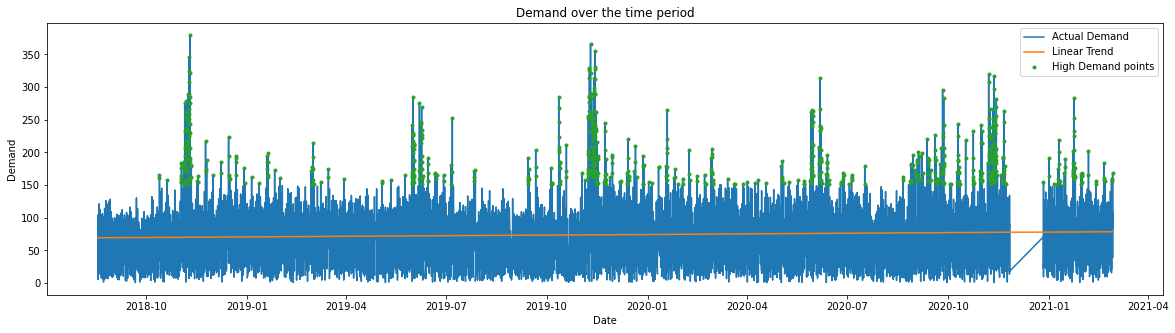

In [10]:
plt.figure(figsize = (20,5))
plt.plot(train.date, train.demand)
plt.plot(train.date, train.linear_trend)
plt.plot(train[train.demand > 150].date, train[train.demand > 150].demand,".")
plt.title("Demand over the time period")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend(["Actual Demand","Linear Trend","High Demand points"])
plt.show()

We can see there isnt much of linear trend in the data. But we can see the peaks are following a systematic pattern like somewhere near mid december or mid november we have the highest demand. Some where near June we have second highest peaks seems like a year end vacation and summer vacation. We can say that there is two are may be more seasonality factors in the Time series


So the approach I will be using is to manually get the seasonality from the series using Fast Fourier Transform. I have used NumPy's inbulit functions fft and ifft. 



## Fast Fourier Transform



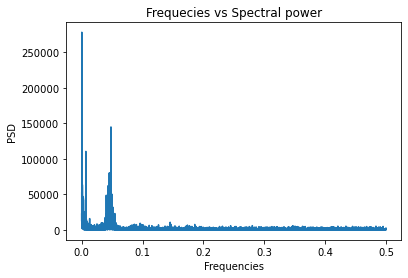

In [11]:

p = np.fft.fft(train.demand)
n = len(train.demand)
psd = (p * np.conj(p))/n
l = np.arange(1,np.floor(n/2), dtype = "int")
freq = (1/(1*n))*np.arange(n)

'''since the fft will give the symmetric result the same result with other sign we will examine only the 
first half of the result'''

plt.plot(freq[l],psd[l].real)
plt.title("Frequecies vs Spectral power")
plt.xlabel("Frequencies")
plt.ylabel("PSD")
plt.show()


We can see there are some frequencies that are standing out from other frequencies. We will filter these frequencies and we will use them in determining the deterministic form of time series. 

C:\Users\SHIVA\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


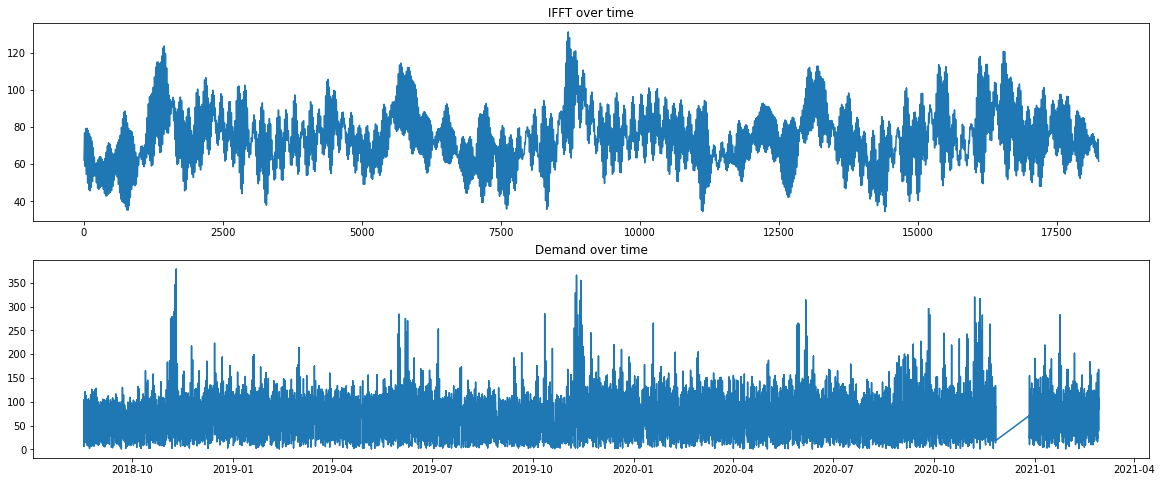

In [13]:
##Applying the inverse fast fourier transform to remove the noise present 
p1 = p* (psd > 50000)  ##Filtering
ifft = np.fft.ifft(p1)  ##IFFT
plt.figure(figsize = (20,8))
plt.subplot(2,1,1)
plt.plot(np.fft.ifft(p1))
plt.title("IFFT over time")
plt.subplot(2,1,2)
plt.plot(train.date,train.demand)
plt.title("Demand over time")
plt.show()

Through the graphs we can see that the IFFT has done pretty good in estimating the peaks. Now the main task is to compute this IFFT result from scratch such that we can project this wave form to test dates and use it in the demand forecasting. Lets try to filter only few frequencies to see whether the code is estimating the IFFT properly or not

In [18]:
ampl = (np.sqrt(p * np.conj(p))/(len(p)/2)).real # Computing the amplitude of the wave

df = pd.DataFrame(zip(freq,psd.real,p.real, p.imag,p,ampl),
                  columns = ["freq","PSD_r","fft_real","fft_imag","fft_tr","ampl"])

df["Theta"] = (df["fft_real"]/df["fft_imag"]).apply(lambda x : math.atan(x)) # Finding the phase

df1 = df.loc[df.PSD_r > 150000,["freq","Theta","ampl"]].reset_index().reset_index(drop = True, inplace=False)
df1

,index,freq,Theta,ampl
0,0,0.000000,1.570796,147.982901
1,5,0.000274,-1.335347,7.812673
2,12,0.000658,0.475143,5.864249
3,18235,0.999342,-0.475143,5.864249
4,18242,0.999726,1.335347,7.812673


From the above result we see that the entries are symmetric. The theta values are getting repeated from either sides. We will be using only the first half of the data frame to estimate the IFFT manually

C:\Users\SHIVA\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


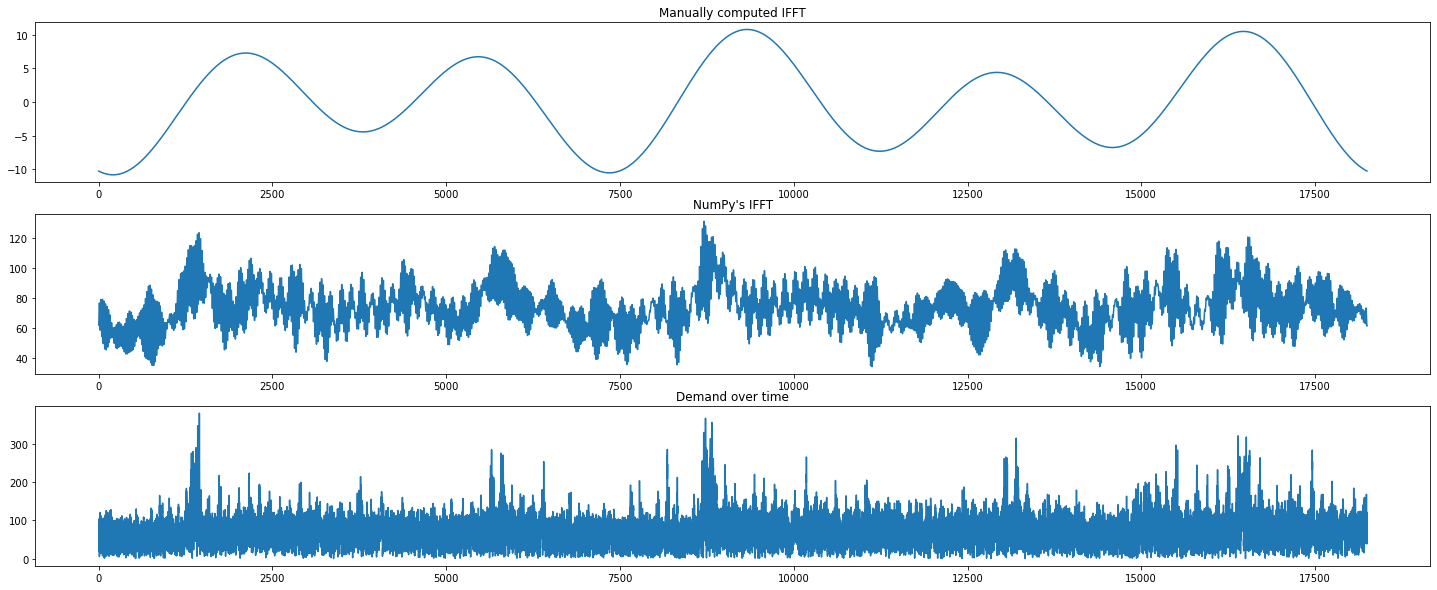

In [26]:
def construct_Waves(time_series, v):
    
    ''' this function will construct the waves given a time series 
    along with the list of freq and phase which is theta'''

    return v[2] * np.sin(2*np.pi*time_series*v[0]+v[1])




time = np.arange(0,len(train.demand)) #Time 



wave = np.zeros(len(time))
for i in range(1,len(df1)-2):
    x = list(df1.loc[i,["freq","Theta","ampl"]])
    x1 = np.array(construct_Waves(time,x))
    wave = wave+x1

wave = list(wave)
wave.reverse()

plt.figure(figsize=(25,10))
plt.subplot(3,1,1)
plt.plot(wave)
plt.title("Manually computed IFFT")
plt.subplot(3,1,2)
plt.plot(ifft)
plt.title("NumPy's IFFT")
plt.subplot(3,1,3)
plt.plot(train.demand)
plt.title("Demand over time")
plt.show()

We can see when we applied a filter for 150000 for frequencies the IFFT we have computed is exactly matching the troughs and crests of the NumPy calculated IFFT.Pearson correlation of 49 percent suggests the same Now Lets add few more frequencies and compute the IFFT

In [27]:
pearsonr(wave, ifft.real)

(0.4308047838423677, 0.0)

In [22]:
ampl = (np.sqrt(p * np.conj(p))/(len(p)/2)).real # Computing the amplitude of the wave

df = pd.DataFrame(zip(freq,psd.real,p.real, p.imag,p,ampl),
                  columns = ["freq","PSD_r","fft_real","fft_imag","fft_tr","ampl"])

df["Theta"] = (df["fft_real"]/df["fft_imag"]).apply(lambda x : math.atan(x)) # Finding the phase

df1 = df.loc[df.PSD_r > 50000,["freq","Theta","ampl"]].reset_index().reset_index(drop = True, inplace=False)
df1

,index,freq,Theta,ampl
0,0,0.000000,1.570796,147.982901
1,3,0.000164,-0.883358,3.409385
2,5,0.000274,-1.335347,7.812673
3,8,0.000438,-0.085472,4.515163
4,12,0.000658,0.475143,5.864249
5,17,0.000932,0.244414,4.558606
6,22,0.001206,-0.191597,3.735436
7,25,0.001370,1.386024,3.582622
8,123,0.006741,-1.147482,3.448033
9,126,0.006905,-0.870894,4.924327


C:\Users\SHIVA\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


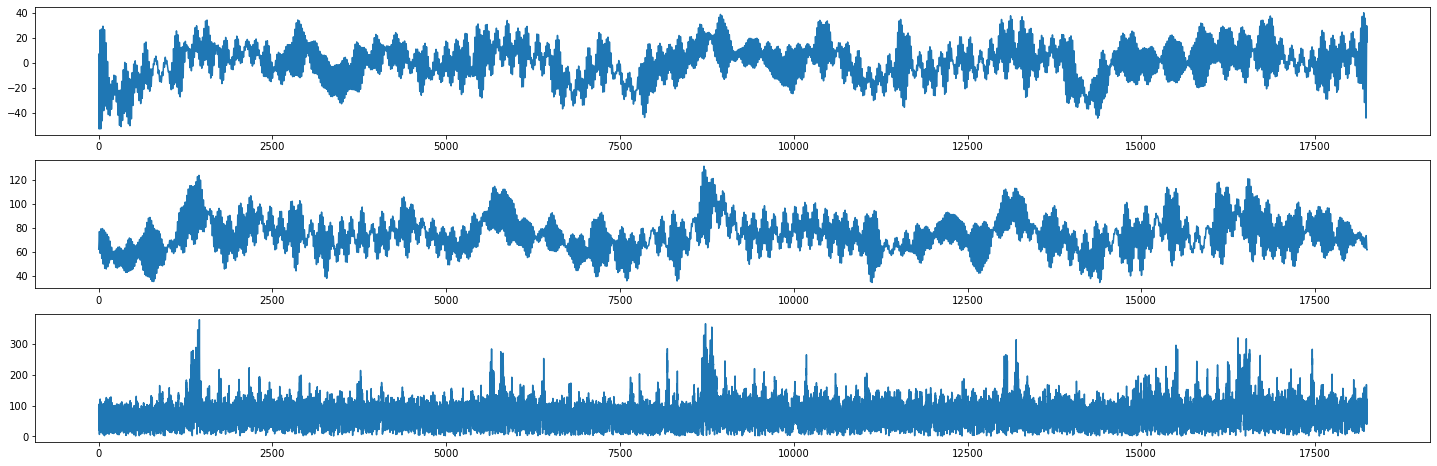

In [28]:
time = np.arange(0,len(train.demand)) #Time 



wave = np.zeros(len(time))
for i in range(1,len(df1)-21):
    x = list(df1.loc[i,["freq","Theta","ampl"]])
    x1 = np.array(construct_Waves(time,x))
    wave = wave+x1

wave = list(wave)
wave.reverse()

plt.figure(figsize=(25,8))
plt.subplot(3,1,1)
plt.plot(wave)
plt.subplot(3,1,2)
plt.plot(ifft)
plt.subplot(3,1,3)
plt.plot(train.demand)

Evem though the Manually computed IFFT and NumPy's FFT arent looking similar lets proceed with the process as I dont have much time.

In [33]:
time = np.arange(0,len(train.demand)+len(test)) #Time 

''' extending the IFFT for test time periods '''

wave = np.zeros(len(time))
for i in range(1,len(df1)-21):
    x = list(df1.loc[i,["freq","Theta","ampl"]])
    x1 = np.array(construct_Waves(time,x))
    wave = wave+x1

wave = list(wave)
wave.reverse()

In [34]:
len(wave[len(train):]), len(test)

(7650, 7650)

In [36]:
test["ifft"] = wave[len(train):]

In [37]:
test["linear_trend"] = 0.00050347 * np.arange(len(train),len(train)+len(test)) + 69.3983208628

## Linear Model

In [42]:
train["ifft"] = wave[:len(train)]
model = linear_model.LinearRegression()
model.fit(train.drop(columns = ["date","min_trend","demand","linear_trend","min_trend"]), train.demand)
predictions = model.predict(test.drop(columns = ["date","linear_trend"]))

In [43]:
test["predictions"] = predictions

In [44]:
sample = pd.read_csv("sample.csv")

In [45]:
sample["demand"] = test.predictions

In [46]:
sample.to_csv("sub6_2404202.csv",index = False)